In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, HTML

base_folder = "../../../../.."

## Topologies

In [2]:
def read_topology(topology_name):
    print(f"Topology name: {topology_name}")
    df = pd.read_csv(f"{base_folder}/resources/env/{topology_name}.txt", delimiter=";")
    display(HTML(df.to_html()))
        
read_topology("multi")
read_topology("single")

Topology name: multi


,ClusterID,ClusterName,Cores,Speed,Memory,numberOfHosts,memoryCapacityPerHost,coreCountPerHost
0,A01,A01,32,3.20,2048,1,256,32
1,B01,B01,48,2.93,1256,6,64,8
2,C01,C01,32,3.20,2048,2,128,16


Topology name: single


,ClusterID,ClusterName,Cores,Speed,Memory,numberOfHosts,memoryCapacityPerHost,coreCountPerHost
0,A01,A01,8,3.2,128,1,128,8


## Traces

In [4]:
df_trace = pd.read_parquet(f"{base_folder}/resources/bitbrains-small/trace/trace.parquet")
df_trace[df_trace["id"] == "1019"]

,id,timestamp,duration,cpu_count,cpu_usage
0,1019,2013-08-12 13:40:46+00:00,300000,1,0.000000
1,1019,2013-08-12 13:45:46+00:00,300000,1,11.703998
2,1019,2013-08-12 13:55:46+00:00,600000,1,0.000000
3,1019,2013-08-12 14:00:46+00:00,300000,1,11.703998
4,1019,2013-08-12 14:15:46+00:00,900000,1,0.000000
...,...,...,...,...,...
6143,1019,2013-09-11 13:14:58+00:00,600000,1,0.000000
6144,1019,2013-09-11 13:19:58+00:00,300000,1,11.704000
6145,1019,2013-09-11 13:29:58+00:00,600000,1,0.000000
6146,1019,2013-09-11 13:34:58+00:00,300000,1,11.704000


In [5]:
df_meta = pd.read_parquet(f"{base_folder}/resources/bitbrains-small/trace/meta.parquet")
df_meta.head()

,id,start_time,stop_time,cpu_count,cpu_capacity,mem_capacity
0,1019,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,1,2926.000135,181352
1,1023,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,1,2925.999560,260096
2,1026,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,1,2925.999717,249972
3,1052,2013-08-29 14:38:12+00:00,2013-09-05 07:09:07+00:00,1,2926.000107,131245
4,1073,2013-08-21 11:07:12+00:00,2013-09-11 13:39:58+00:00,1,2599.999649,179306


In [6]:
df_meta_new = df_meta[df_meta["start_time"] == df_meta["start_time"].min()].iloc[:20]

In [7]:
output_file = "../Python_scripts/meta_small.parquet"
output_file_path = Path(output_file)

df_meta_new.to_parquet(output_file_path, index=False)

output_file = "../Python_scripts/trace_small.parquet"
output_file_path = Path(output_file)
df_trace_new.to_parquet(output_file_path, index=False)

NameError: name 'Path' is not defined

# Lets run this in OpenDC!

## Resulting Files

In [31]:
output_folder = f"{base_folder}/output"
workload = "workload=bitbrains-small"
seed = "seed=0"

df_host_single = pd.read_parquet(f"{output_folder}/host/topology=single/{workload}/{seed}/data.parquet")
df_host_multi = pd.read_parquet(f"{output_folder}/host/topology=multi/{workload}/{seed}/data.parquet")

df_server_single = pd.read_parquet(f"{output_folder}/server/topology=single/{workload}/{seed}/data.parquet")
df_server_multi = pd.read_parquet(f"{output_folder}/server/topology=multi/{workload}/{seed}/data.parquet")

df_service_single = pd.read_parquet(f"{output_folder}/service/topology=single/{workload}/{seed}/data.parquet")
df_service_multi = pd.read_parquet(f"{output_folder}/service/topology=multi/{workload}/{seed}/data.parquet")

def add_absolute_timestamp(df, start_dt):
    df["absolute_timestamp"] = start_dt + (df["timestamp"] - df["timestamp"].min())

add_absolute_timestamp(df_host_single, df_meta["start_time"].min())
add_absolute_timestamp(df_host_single, df_meta["start_time"].min())

add_absolute_timestamp(df_server_single, df_meta["start_time"].min())
add_absolute_timestamp(df_server_multi, df_meta["start_time"].min())

add_absolute_timestamp(df_service_single, df_meta["start_time"].min())
add_absolute_timestamp(df_service_multi, df_meta["start_time"].min())

In [51]:
df_service_multi

,timestamp,hosts_up,hosts_down,servers_pending,servers_active,attempts_success,attempts_failure,attempts_error,absolute_timestamp
0,1970-01-01 00:04:00+00:00,9,0,44,0,0,0,0,2013-08-12 13:35:46+00:00
1,1970-01-01 00:04:00+00:00,9,0,44,0,0,0,0,2013-08-12 13:35:46+00:00
2,1970-01-01 00:04:00+00:00,9,0,44,0,0,0,0,2013-08-12 13:35:46+00:00
3,1970-01-01 00:04:00+00:00,9,0,44,0,0,0,0,2013-08-12 13:35:46+00:00
4,1970-01-01 00:05:00+00:00,9,0,0,44,44,0,0,2013-08-12 13:36:46+00:00
...,...,...,...,...,...,...,...,...,...
43205,1970-01-31 00:06:00+00:00,9,0,0,47,50,0,0,2013-09-11 13:37:46+00:00
43206,1970-01-31 00:07:00+00:00,9,0,0,47,50,0,0,2013-09-11 13:38:46+00:00
43207,1970-01-31 00:08:00+00:00,9,0,0,44,50,0,0,2013-09-11 13:39:46+00:00
43208,1970-01-31 00:09:00+00:00,9,0,0,44,50,0,0,2013-09-11 13:40:46+00:00


## Power Usage

In [10]:
print(f"single topology:  {df_host_single.power_total.sum()}")
print(f"multi topology:   {df_host_multi.power_total.sum()}")

single topology:  2227379391.0896
multi topology:   5865296669.647482


## CPU usage

In [11]:
print(f"single topology:  {df_host_single.cpu_utilization.mean()}")
print(f"multi topology:   {df_host_multi.cpu_utilization.mean()}")

single topology:  0.5759617370100649
multi topology:   0.3424842677740509


## CPU utilization

In [12]:
print(f"single topology:  {df_host_single.cpu_utilization.mean()}")
print(f"multi topology:   {df_host_multi.cpu_utilization.mean()}")

single topology:  0.5759617370100649
multi topology:   0.3424842677740509


## Plotting Results

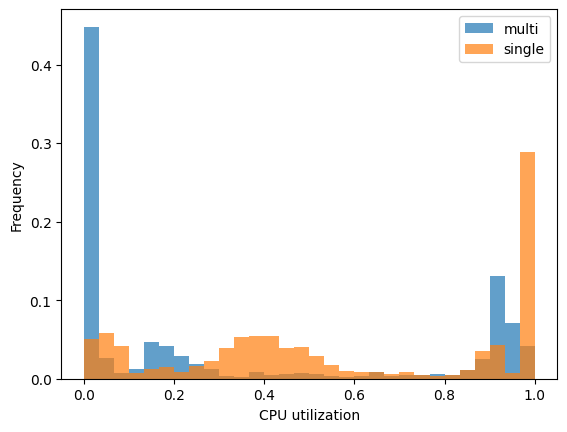

In [14]:
data = df_host_multi.cpu_utilization
plt.hist(data, weights=np.ones_like(data) / len(data),
         alpha=0.7, label="multi", bins=30)


data = df_host_single.cpu_utilization
plt.hist(data, weights=np.ones_like(data) / len(data),
         alpha=0.7, label="single", bins=30)

plt.xlabel("CPU utilization")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [15]:
df_host_single.cpu_utilization.value_counts()

1.000000    36807
0.026394       10
0.063165       10
0.080042       10
0.021973       10
            ...  
0.519209        1
0.505311        1
0.494024        1
0.493425        1
0.385138        1
Name: cpu_utilization, Length: 19790, dtype: int64

In [122]:
df_host_multi.host_id.unique()

array([b'\xf8\x8b\xb8\xa8rL\x81\xec\x00\x00\x00\x00\x00\x00\x00\x02',
       b'\x1b9\x89jQ\xa8t\x9b\x00\x00\x00\x00\x00\x00\x00\x03',
       b'\xc5\x84\x13:\xc9\x16\xab<\x00\x00\x00\x00\x00\x00\x00\x00',
       b'S\xcb\x9f\x0ct~\xa2\xea\x00\x00\x00\x00\x00\x00\x00\x04',
       b'\xe2 \xa89{\x1d\xcd\xaf\x00\x00\x00\x00\x00\x00\x00\x00',
       b'\x06\xc4]\x18\x80\tEO\x00\x00\x00\x00\x00\x00\x00\x01',
       b',\x82\x9a\xbe\x1fE2\xe1\x00\x00\x00\x00\x00\x00\x00\x05',
       b'>\xe5x\x90A\xc9\x8a\xc3\x00\x00\x00\x00\x00\x00\x00\x01',
       b'nx\x9ej\xa1\xb9e\xf4\x00\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)

In [123]:
df_server_single.cpu_count.value_counts()

1     704537
4     590697
8     388895
2     312916
32     43210
Name: cpu_count, dtype: int64

In [124]:
print(len(df_service_multi))
print(len(df_service_single))

43209
43215


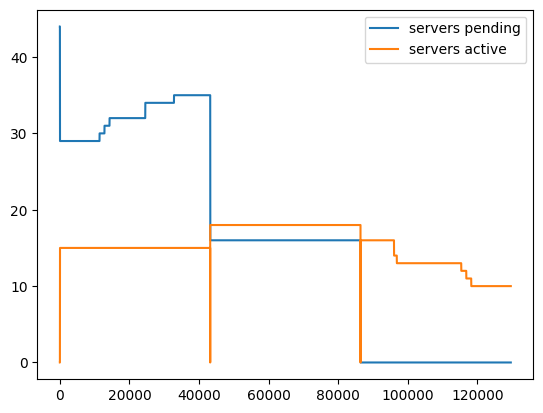

In [23]:
import matplotlib.pyplot as plt

plt.plot(df_service_single.servers_pending, label="servers pending")
plt.plot(df_service_single.servers_active, label="servers active")

plt.legend()

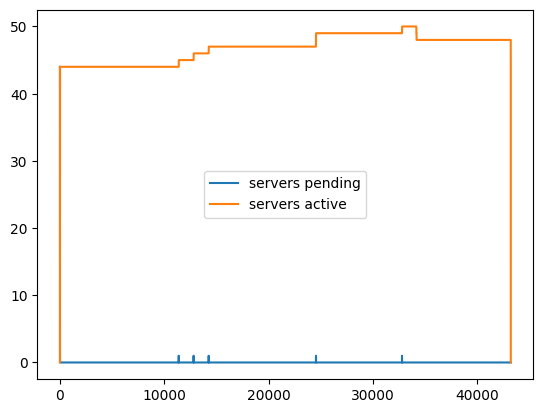

In [50]:
import matplotlib.pyplot as plt

plt.plot(df_service_multi.servers_pending, label="servers pending")
plt.plot(df_service_multi.servers_active, label="servers active")

plt.legend()

In [23]:
df_service_single.tail()

,timestamp,hosts_up,hosts_down,servers_pending,servers_active,attempts_success,attempts_failure,attempts_error,absolute_timestamp
129629,1970-04-01 00:30:00+00:00,1,0,0,10,49,1,0,2013-11-10 14:04:46+00:00
129630,1970-04-01 00:31:00+00:00,1,0,0,10,49,1,0,2013-11-10 14:05:46+00:00
129631,1970-04-01 00:32:00+00:00,1,0,0,10,49,1,0,2013-11-10 14:06:46+00:00
129632,1970-04-01 00:33:00+00:00,1,0,0,10,49,1,0,2013-11-10 14:07:46+00:00
129633,1970-04-01 00:34:00+00:00,1,0,0,10,49,1,0,2013-11-10 14:08:46+00:00


In [24]:
df_service_multi.tail()

,timestamp,hosts_up,hosts_down,servers_pending,servers_active,attempts_success,attempts_failure,attempts_error,absolute_timestamp
43209,1970-01-31 00:10:00+00:00,9,0,0,48,50,0,0,2013-09-11 13:41:46+00:00
43210,1970-01-31 00:11:00+00:00,9,0,0,48,50,0,0,2013-09-11 13:42:46+00:00
43211,1970-01-31 00:12:00+00:00,9,0,0,47,50,0,0,2013-09-11 13:43:46+00:00
43212,1970-01-31 00:13:00+00:00,9,0,0,44,50,0,0,2013-09-11 13:44:46+00:00
43213,1970-01-31 00:14:00+00:00,9,0,0,44,50,0,0,2013-09-11 13:45:46+00:00


In [213]:
df_host_single.columns

Index(['timestamp', 'host_id', 'cpu_count', 'mem_capacity',
       'guests_terminated', 'guests_running', 'guests_error', 'guests_invalid',
       'cpu_limit', 'cpu_usage', 'cpu_demand', 'cpu_utilization',
       'cpu_time_active', 'cpu_time_idle', 'cpu_time_steal', 'cpu_time_lost',
       'power_total', 'uptime', 'downtime', 'boot_time', 'absolute_timestamp'],
      dtype='object')

In [227]:
df_server_single.timestamp.value_counts()

1970-01-31 00:09:00+00:00    4089
1970-01-28 01:28:00+00:00    4003
1970-01-18 12:18:00+00:00    3931
1970-01-16 23:01:00+00:00    3825
1970-01-23 07:56:00+00:00    3722
                             ... 
1970-01-15 05:13:00+00:00       1
1970-01-15 05:10:00+00:00       1
1970-01-01 14:08:00+00:00       1
1970-01-15 05:00:00+00:00       1
1970-01-14 20:07:00+00:00       1
Name: timestamp, Length: 40625, dtype: int64

In [230]:
df_host_single.tail()

,timestamp,host_id,cpu_count,mem_capacity,guests_terminated,guests_running,guests_error,guests_invalid,cpu_limit,cpu_usage,...,cpu_utilization,cpu_time_active,cpu_time_idle,cpu_time_steal,cpu_time_lost,power_total,uptime,downtime,boot_time,absolute_timestamp
43210,1970-01-31 00:11:00+00:00,b'\xe2 \xa89{\x1d\xcd\xaf\x00\x00\x00\x00\x00\...,8,128000,0,0,0,0,25600.0,0.21875,...,0.000009,0,480,0,0,12000.226863,60000,0,1970-01-01 00:00:00+00:00,2013-09-11 13:45:46+00:00
43211,1970-01-31 00:12:00+00:00,b'\xe2 \xa89{\x1d\xcd\xaf\x00\x00\x00\x00\x00\...,8,128000,0,0,0,0,25600.0,0.21875,...,0.000009,0,480,0,0,12000.076864,60000,0,1970-01-01 00:00:00+00:00,2013-09-11 13:46:46+00:00
43212,1970-01-31 00:13:00+00:00,b'\xe2 \xa89{\x1d\xcd\xaf\x00\x00\x00\x00\x00\...,8,128000,0,0,0,0,25600.0,0.21875,...,0.000009,0,480,0,0,12000.076864,60000,0,1970-01-01 00:00:00+00:00,2013-09-11 13:47:46+00:00
43213,1970-01-31 00:14:00+00:00,b'\xe2 \xa89{\x1d\xcd\xaf\x00\x00\x00\x00\x00\...,8,128000,0,0,0,0,25600.0,0.21875,...,0.000009,0,480,0,0,12000.076864,60000,0,1970-01-01 00:00:00+00:00,2013-09-11 13:48:46+00:00
43214,1970-01-31 00:15:00+00:00,b'\xe2 \xa89{\x1d\xcd\xaf\x00\x00\x00\x00\x00\...,8,128000,0,16,0,0,25600.0,0.21875,...,0.000009,0,480,0,0,12000.076864,60000,0,1970-01-01 00:00:00+00:00,2013-09-11 13:49:46+00:00


In [239]:
df_service_single.tail(10)

,timestamp,hosts_up,hosts_down,servers_pending,servers_active,attempts_success,attempts_failure,attempts_error,absolute_timestamp
43205,1970-01-31 00:06:00+00:00,1,0,35,15,15,0,0,2013-09-11 13:40:46+00:00
43206,1970-01-31 00:07:00+00:00,1,0,35,15,15,0,0,2013-09-11 13:41:46+00:00
43207,1970-01-31 00:08:00+00:00,1,0,35,15,15,0,0,2013-09-11 13:42:46+00:00
43208,1970-01-31 00:09:00+00:00,1,0,35,15,15,0,0,2013-09-11 13:43:46+00:00
43209,1970-01-31 00:10:00+00:00,1,0,35,0,15,0,0,2013-09-11 13:44:46+00:00
43210,1970-01-31 00:11:00+00:00,1,0,16,0,33,1,0,2013-09-11 13:45:46+00:00
43211,1970-01-31 00:13:00+00:00,1,0,16,0,33,1,0,2013-09-11 13:47:46+00:00
43212,1970-01-31 00:13:00+00:00,1,0,16,0,33,1,0,2013-09-11 13:47:46+00:00
43213,1970-01-31 00:14:00+00:00,1,0,16,0,33,1,0,2013-09-11 13:48:46+00:00
43214,1970-01-31 00:15:00+00:00,1,0,0,16,49,1,0,2013-09-11 13:49:46+00:00


In [237]:
df_meta.sort_values("start_time").reset_index()

,index,id,start_time,stop_time,cpu_count,cpu_capacity,mem_capacity
0,0,1019,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,1,2926.000135,181352
1,26,466,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,4,10399.997372,3141632
2,27,467,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,4,10399.998408,3133440
3,28,501,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,4,10399.999796,3141632
4,29,506,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,4,10399.998452,3133440
5,30,550,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,1,2599.999951,1867776
6,31,554,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,1,2926.000135,4194304
7,33,578,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,1,2599.999626,2092352
8,34,607,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,1,2599.999626,4058292
9,35,626,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,4,10399.998504,16355328


In [36]:
utilization = df_host_single.cpu_utilization.to_numpy()

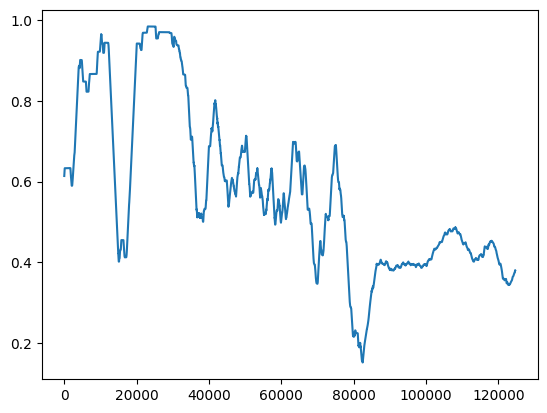

In [46]:
window = 5000
avg_utilization = []

for ind in range(len(utilization) - window + 1):
    avg_utilization.append(np.mean(utilization[ind:ind+window]))
    
plt.plot(avg_utilization)

In [47]:
sum_util = []

last_util = 0
for util in utilization:
    sum_util.append(util + last_util)
    last_util = sum_util[-1]

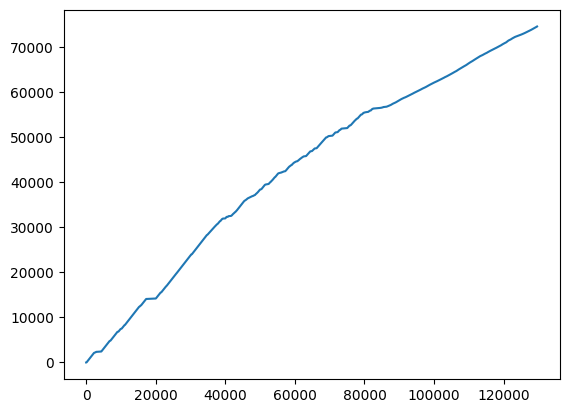

In [49]:
plt.plot(sum_util)